This notebook shows how ensemble-based uncertainty computation could be used on real data. More specifically, the further analysis provided for the MC-Dropout virtual ensemble trained on a RICH dataset. This notebook contains only code snippets and results based on the already trained model.

**NOTE!** The code uses processed data from the LHCb experiment. Collaboration members please write nikita.kazeev@cern.ch for access.

In [ ]:
!pip install tensorflow-addons

In [4]:
import datetime
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from experiments.efficiency.uncertainty_model_train import train_model
from experiments.efficiency.uncertainty_models import uncertainty_mlp
from experiments.efficiency.uncertainty_utils import \
    efficiency_momentum_with_uncertainty
from experiments.efficiency.utils import (efficiency_momentum,
                                          ensemble_and_ref_model_inference,
                                          tf_to_numpy_dataset,
                                          threshold_selection)

from src.cramer_gan_trainer import CramerGANTrainer
from src.datasets.utils_rich import (get_merged_typed_dataset,
                                     parse_dataset_np, parse_example)

from src.models.gans.discriminators.fcn_disc import RICHDiscriminator
from src.models.gans.generators.fcn_gen import RichMCDropV2Subcl

In [ ]:
# suppresses tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Data preparation

The RICH dataset contains sets of data for different types of particles. Each datapoint in RICH consists of $\mathbb{X}, \mathbb{Y}$ and weight $w$, where the input data $\mathbb{X} \in \mathbb{R}^3$, where features of input data consist of pseudorapidity (ETA), momentum (P), number of tracks; the output is data $\mathbb{Y} \in \mathbb{R}^5$, where each feature is the difference of log-likelihood values between particle hypothesis and pion hypothesis. The particles are kaon, proton, muon, electron, and values below the threshold. Without loss of generality, the data for **pion** particle was chosen. Pion data will be used for further analysis. In this notebook we use IID train/test split for experiments with efficiency.

In [11]:
particle_type = 'pion'

data_dir = 'rich'

In [12]:
ls rich

kaon2_-_down_2016_.csv  muon_-_down_2016_.csv   pion_-_down_2016_.csv
kaon2_+_down_2016_.csv  muon_+_down_2016_.csv   pion_+_down_2016_.csv
kaon2_-_up_2016_.csv    muon_-_up_2016_.csv     pion_-_up_2016_.csv
kaon2_+_up_2016_.csv    muon_+_up_2016_.csv     pion_+_up_2016_.csv
kaon_-_down_2016_.csv   pion2_-_down_2016_.csv  proton_-_down_2016_.csv
kaon_+_down_2016_.csv   pion2_+_down_2016_.csv  proton_+_down_2016_.csv
kaon_-_up_2016_.csv     pion2_-_up_2016_.csv    proton_-_up_2016_.csv
kaon_+_up_2016_.csv     pion2_+_up_2016_.csv    proton_+_up_2016_.csv


In [13]:
data_train, data_val, scaler = get_merged_typed_dataset(data_dir, particle_type, dtype=np.float32, log=True)

Reading and concatenating datasets:
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_-_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_+_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_-_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion_+_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_-_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_+_down_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_-_up_2016_.csv
	drive/MyDrive/uncertainty-colab/datasets/rich/pion2_+_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.017943859100342
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>


In [14]:
data_train.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
0  1.374413 -0.168298   0.839823  ...   -0.306364       -0.224346       1.204700
1 -1.254825 -0.040824  -1.886267  ...   -0.669189       -0.548956       0.965707
2  0.931232  1.038058   0.607882  ...    1.356350       -0.475871       0.665584
3  1.128034 -0.207232   0.942811  ...    0.534500       -1.278361       0.581925
4  1.315219 -0.190440   1.180111  ...    0.147866       -0.578887       0.118914

[5 rows x 9 columns]

In [15]:
data_val.head()

RichDLLe  RichDLLk  RichDLLmu  ...  Brunel_ETA  nTracks_Brunel  probe_sWeight
0  0.642078  0.247975   0.790279  ...    1.312073       -0.548956       0.859352
1  0.410903 -2.077369   0.448014  ...   -2.181621        0.474075       0.957473
2 -0.653586 -1.325109  -0.581912  ...   -0.918851        0.748689       0.825602
3 -0.396800 -1.025127   1.549422  ...    1.381592       -0.608697      -1.011210
4  0.295756  0.260714  -0.013731  ...    0.593576        1.160335       1.234150

[5 rows x 9 columns]

In [16]:
feats_train, targets_train, _ = parse_dataset_np(data_train)
feats_val, targets_val, _ = parse_dataset_np(data_val)

feats_train.shape, targets_train.shape, feats_val.shape, targets_val.shape

((2000000, 3), (2000000, 5), (1000000, 3), (1000000, 5))

### Model definition, restoring from checkpoint

This chapter contains the only model definition and restores the model from the checkpoint. It does not contain training/evaluation routines since it was done in another notebook (look Train.ipynb notebook).

In [17]:
generator = RichMCDropV2Subcl(drop_rate=0.2)
generator.build((None, 3))
generator.summary()

Dropout type: gaussian
Dropout type: gaussian
Dropout type: gaussian
Dropout type: gaussian
Dropout type: gaussian
Model: "rich_mc_drop_v2_subcl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_drop (DenseDrop)       multiple                  8704      
_________________________________________________________________
dense_drop_1 (DenseDrop)     multiple                  16512     
_________________________________________________________________
dense_drop_2 (DenseDrop)     multiple                  16512     
_________________________________________________________________
dense_drop_3 (DenseDrop)     multiple                  16512     
_________________________________________________________________
dense_drop_4 (DenseDrop)     multiple                  16512     
_________________________________________________________________
dense_5 (Dense)              multiple                  645    

In [18]:
discriminator = RICHDiscriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8)            0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          100224      concatenate[0][0]            

In [ ]:
checkpoint_base = 'checkpoints'
ckpt_name = 'mcdrop_gaussian_line_test_cramer_weighted'
checkpoint_dir = os.path.join(checkpoint_base, ckpt_name)

log_dir = 'log_dir_tmp'

generator_optimizer = tf.keras.optimizers.RMSprop(2e-4) 
discriminator_optimizer = tf.keras.optimizers.RMSprop(2e-4)

trainer_config = {
    'generator': generator,
    'discriminator': discriminator,
    'generator_optimizer': generator_optimizer,
    'discriminator_optimizer': discriminator_optimizer,
    'checkpoint_dir': checkpoint_dir,
    'log_dir': log_dir
}

trainer = CramerGANTrainer(**trainer_config)
trainer.restore_last()

### Efficinecy computation

Since we are focused on assessing the systematic uncertainty and taking into account the fact that after standardization, the distribution of each $y_i$ is close to Gaussian, we may follow the Lucio's [proposal](https://colab.research.google.com/drive/1ypWf-J1buJ4svNvTKrvk4kQTYfjOnbrM?usp=sharing), i.e., the $\sigma_{systematic}$ could be approximated as 
$$\sigma^{systematic}_i = \sqrt{\frac{1}{2} (\mathbb{E}_{reference}[(y^{(1)}_i - y^{(2)}_i)^2] - \mathbb{E}_{ensemble}[(y^{(1)}_i - y^{(2)}_i)^2])},$$ where $y^{(1)}_i$ and $y^{(2)}_i$ are two randomly picked examples of target feature $y_i$, and $\mathbb{E}_{reference}$ and $\mathbb{E}_{ensemble}$ are the average operators computed across data produced by reference model and ensemble model respectively. The lightweight solution (without additional reference and ensemble models inference each time) is to learn models to approximate the residuals well. Since train and test splits follow close distributions, fitting residuals on training data is enough to compute demanding confidence bounds.

In [24]:
ensemble_size = 4
ensemble_preds, ref_model_preds = ensemble_and_ref_model_inference(generator, 
                                                                   feats_train, 
                                                                   ensemble_size)

ensemble_preds_val, ref_model_preds_val = ensemble_and_ref_model_inference(generator, 
                                                                           feats_val, 
                                                                           ensemble_size)

100%|██████████| 8/8 [00:01<00:00,  5.50it/s]


In [25]:
input_data = np.repeat(feats_train, ensemble_size, axis=0)

y_ref = np.concatenate([np.abs(p1 - p2) 
                        for p1, p2 in zip(ref_model_preds[:ensemble_size], 
                                          ref_model_preds[ensemble_size:])])

y_ens = np.concatenate([np.abs(p1 - p2) 
                        for p1, p2 in zip(ensemble_preds, 
                                          ref_model_preds)])

input_data.shape, y_ref.shape, y_ens.shape

((8000000, 3), (8000000, 5), (16000000, 5))

In [ ]:
# Uncomment and run cell to remove checkpoints
# !rm -rf /content/drive/MyDrive/gan-uncertainty-hyper-gan/experiments/efficiency/uncertainty_weights/iid_ref

As discussed above, uncertainty computation requires training models which capture residuals. Below is shown training of these models. In our case, both models are simple 4-layer mlp with three hidden layers of 128 units. The loss function is MSE, Adam optimizer; Reduce on plateau approach is used for more efficient learning rate scheduling. Other parameters: initial learning rate is 1e-3, the batch size is 1e5. Models are trained for 100 epochs.

In [26]:
base_path = 'experiments/efficiency/uncertainty_weights/'
save_path_ref_model = os.path.join(base_path, 'iid_ref', 'model_{epoch}')

ref_unc_model = uncertainty_mlp()
ref_unc_train_history = train_model(ref_unc_model, input_data, y_ref, 
                                    save_path_ref_model, lr=1e-3, batch_size=int(1e5), epochs=100)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

In [ ]:
# Uncomment and run cell to remove checkpoints
# !rm -rf  /content/drive/MyDrive/gan-uncertainty-hyper-gan/experiments/efficiency/uncertainty_weights/iid_ens

In [27]:
save_path_ens_model = os.path.join(base_path, 'iid_ens', 'model_{epoch}')

ens_unc_model = uncertainty_mlp()
ens_unc_train_history = train_model(ens_unc_model, input_data, y_ens, 
                                    save_path_ens_model, lr=1e-3, batch_size=int(1e5), epochs=100)

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

### Efficiency

In this experiment, the efficiencies are computed for different ranges of momentum. The step size is fixed.

#### Results

Finally, we compute efficiency for each RichDLL and compute uncertainty bounds for momentum. For prediction, we use a reference model, which is not a part of the ensemble.

In [28]:
def parse_momentum_inverse(data, log=True, momentum_idx=5):
    momentum = scaler.inverse_transform(data.iloc[:, :8])[:, momentum_idx]

    if log:
        momentum = np.log10(momentum)
    return momentum


def log10_inverse(x):
    return np.power(10, x)

In [29]:
dll_columns = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

momentum_val = parse_momentum_inverse(data_val, log=True)
momentum_val.min(), momentum_val.max()

(3.070086, 6.104501)

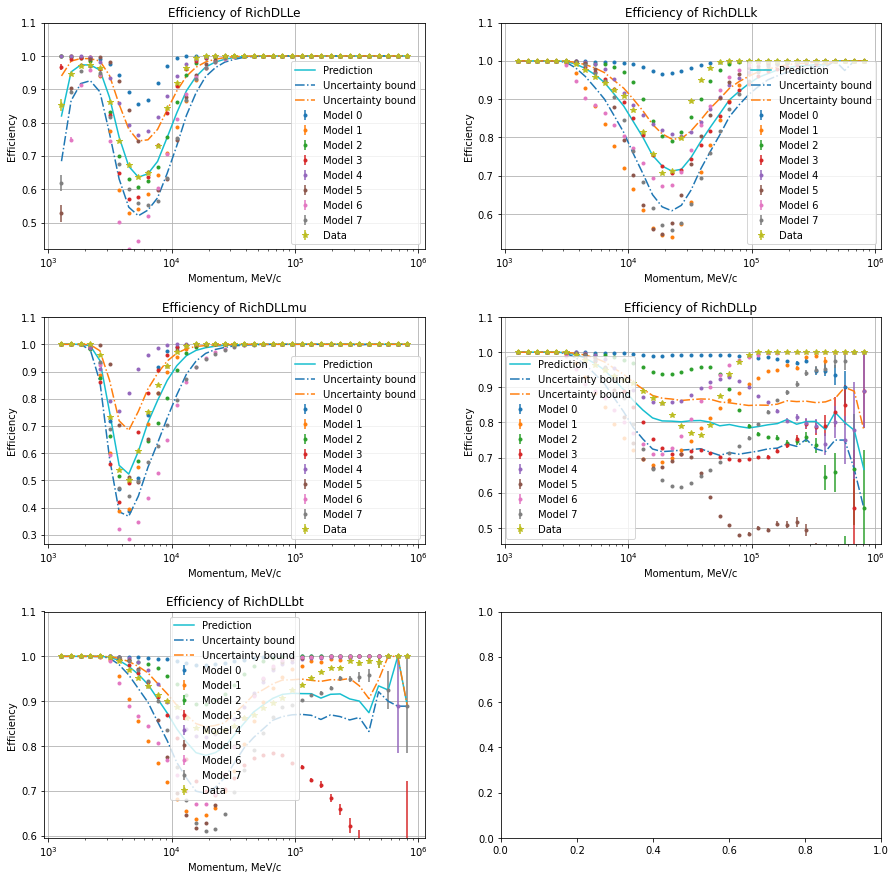

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace = .3)

n_bounds = 40

for idx, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    threshold = threshold_selection(targets_train[:, idx])

    for i, pred in enumerate(ensemble_preds_val):
        x, eff, err = efficiency_momentum(momentum_val, pred[:, idx], threshold, num_boundaries=n_bounds)
        ax.errorbar(log10_inverse(x), eff, err, fmt='.', label=f'Model {i}')
    
    ref_targets_val = ref_model_preds_val[0][:, idx]
    x, efficiency, eff_low, eff_high, errors = efficiency_momentum_with_uncertainty(momentum_val, 
                                                                                    ref_targets_val, 
                                                                                    feats_val, 
                                                                                    ens_unc_model,
                                                                                    ref_unc_model,
                                                                                    threshold, 
                                                                                    idx,
                                                                                    num_boundaries=n_bounds)

    x, eff, err = efficiency_momentum(momentum_val, targets_val[:, idx], threshold, num_boundaries=n_bounds)
    ax.errorbar(log10_inverse(x), eff, err, fmt='*', label='Data')

    ax.plot (log10_inverse(x), efficiency, '-', label='Prediction')
    ax.plot (log10_inverse(x), eff_high, '-.', label='Uncertainty bound')
    ax.plot (log10_inverse(x), eff_low, '-.', label='Uncertainty bound')

    y_low = min(eff_high) - 0.1

    ax.set_title (f"Efficiency of {dll_columns[idx]}")
    ax.set_xlabel("Momentum, MeV/c")
    ax.set_ylabel("Efficiency")
    ax.set_ylim(y_low, 1.1)
    ax.set_xscale('log')
    ax.grid()
    ax.legend()

plt.show()
fig.savefig('efficinecy_plots.jpg')